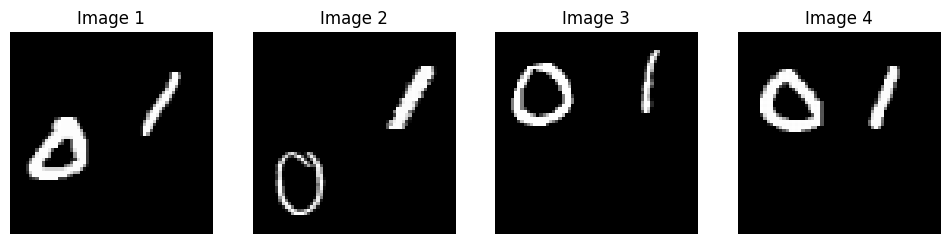

In [3]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread
root_directory = './double_mnist'
def display_images_from_folder(folder_path, num_images=4):
    image_files = os.listdir(folder_path)
    random_images = random.sample(image_files, num_images)
    
    plt.figure(figsize=(12, 6))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(folder_path, image_file)
        image = imread(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Image {i + 1}")
        plt.axis('off')
    plt.show()
train_folder = os.path.join(root_directory, 'train', '01') 
display_images_from_folder(train_folder)


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import numpy as np
import os
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data_path = 'double_mnist/train'
val_data_path = 'double_mnist/val'
test_data_path = 'double_mnist/test'
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        folder_name = os.path.basename(os.path.dirname(path))
        return sample, int(folder_name) 
    
train_dataset = CustomImageFolder(train_data_path, transform=transform)
val_dataset = CustomImageFolder(val_data_path, transform=transform)
test_dataset = CustomImageFolder(test_data_path, transform=transform)
print(train_dataset.classes)
class_to_label = {str(i).zfill(2): i for i in range(100)}
# Define batch sizes
batch_size = 64
print(train_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_classes = 10
class_names = train_dataset.classes
class_names = val_dataset.classes
# print(class_names)
# for images, labels in train_loader:
#     print(labels)
#     break
# for images, labels in val_loader:
#     plt.imshow(images[0].permute(1, 2, 0))
#     print(labels[0])
#     print(labels)
#     break

['00', '01', '04', '05', '06', '08', '09', '11', '12', '13', '14', '15', '16', '18', '19', '20', '21', '23', '24', '26', '28', '29', '30', '31', '33', '35', '37', '38', '41', '42', '43', '44', '45', '50', '51', '53', '54', '56', '59', '60', '62', '63', '65', '69', '70', '72', '74', '75', '76', '77', '79', '81', '82', '84', '85', '87', '88', '89', '90', '91', '94', '95', '97', '98']
Dataset CustomImageFolder
    Number of datapoints: 64000
    Root location: double_mnist/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


# MLP On Double-MNIST

In [2]:
import torch
import torch.nn as nn

class MultiMNIST_MLP(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layers, hidden_neurons, dropout_rate=0.5):
        super(MultiMNIST_MLP, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        layers = []
        layers.append(nn.Linear(input_size, hidden_neurons[0]))
        layers.append(nn.ReLU())
        for i in range(1, hidden_layers):
            layers.append(nn.Linear(hidden_neurons[i-1], hidden_neurons[i]))
            layers.append(nn.ReLU())
        self.hidden = nn.Sequential(*layers)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(hidden_neurons[-1], num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = self.hidden(x)
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

In [3]:
def train_model(model_left, model_right , train_loader, val_loader, criterion_left, optimizer_left, criterion_right, optimizer_right,num_epochs=5):
    train_losses, val_losses = [], []
    train_acc, val_acc = [] , []

    for epoch in range(num_epochs):
        # left half
        model_left.train()
        running_loss_left = 0.0
        correct_train_left = 0
        total_train_left = 0

        # right half
        model_right.train()
        running_loss_right = 0.0
        correct_train_right = 0
        total_train_right = 0

        for images, labels in train_loader:
            # left half
            labels_group_left = labels//10
            optimizer_left.zero_grad()
            image_left = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image_left[:, :, :, (image_left.shape[3] // 2):] = left_half
            outputs_left = model_left(image_left)
            loss_left = criterion_left(outputs_left, labels_group_left)
            loss_left.backward()
            optimizer_left.step()
            running_loss_left += loss_left.item()
            _, predicted_left = torch.max(outputs_left.data, 1)
            total_train_left += labels.size(0)
            for k in range(labels.size(0)):
                if(labels_group_left[k]==predicted_left[k]):
                    correct_train_left = correct_train_left+1
            # right half
            labels_group_right = labels % 10
            optimizer_right.zero_grad()
            image_right = images.clone()
            right_half = images[:, :, :, images.shape[3] // 2:]
            image_right[:, :, :, :(image_right.shape[3] // 2)] = right_half
            outputs_right = model_right(image_right)
            loss_right = criterion_right(outputs_right, labels_group_right)
            loss_right.backward()
            optimizer_right.step()
            running_loss_right += loss_right.item()
            _, predicted_right = torch.max(outputs_right.data, 1)
            total_train_right += labels.size(0)
            for k in range(labels.size(0)):
                if(labels_group_right[k]==predicted_right[k]):
                    correct_train_right = correct_train_right+1


        train_accuracy = 100 * (correct_train_left+correct_train_right) / (total_train_left+total_train_right)
        train_losses.append((running_loss_right+running_loss_left) / (2*len(train_loader)))
        train_acc.append(train_accuracy)
        # left half
        model_left.eval()
        val_loss_left = 0.0
        correct_val_left = 0
        total_val_left = 0
        count_left = 0
        # right half
        model_right.eval()
        val_loss_right = 0.0
        correct_val_right = 0
        total_val_right = 0
        count_right = 0
        with torch.no_grad():
            for images, labels in val_loader:
                # left half
                labels_group_left = labels // 10
                image_left = images.clone()
                left_half = images[:, :, :, :images.shape[3] // 2]
                image_left[:, :, :, (image_left.shape[3] // 2):] = left_half
                outputs_left = model_left(image_left)
                loss_left = criterion_left(outputs_left, labels_group_left)
                val_loss_left += loss_left.item()
                _, predicted_left = torch.max(outputs_left.data, 1)
                total_val_left += labels.size(0)
                correct_val_left += (predicted_left == labels_group_left).sum().item()
                count_left = count_left+1
                # right half
                labels_group_right = labels % 10
                image_right = images.clone()
                right_half = images[:, :, :, images.shape[3] // 2:]
                image_right[:, :, :, :(image_right.shape[3] // 2)] = right_half
                outputs_right = model_right(image_right)
                loss_right = criterion_right(outputs_right, labels_group_right)
                val_loss_right += loss_right.item()
                _, predicted_right = torch.max(outputs_right.data, 1)
                total_val_right += labels.size(0)
                correct_val_right += (predicted_right == labels_group_right).sum().item()
                count_right = count_right+1

            val_accuracy = 100 * (correct_val_left+correct_val_right) / (total_val_left+total_val_right)
            val_losses.append((val_loss_left+val_loss_right) / (2*len(val_loader)))
            val_acc.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc


def test_model(model_left, model_right , test_loader, criterion_left,criterion_right):
    # left half
    model_left.eval()
    test_loss_left = 0.0
    correct_test_left = 0
    total_test_left = 0
    count_left = 0
    # right half
    model_right.eval()
    test_loss_right = 0.0
    correct_test_right = 0
    total_test_right = 0
    count_right = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # left half
            labels_group_left = labels // 10
            image_left = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image_left[:, :, :, (image_left.shape[3] // 2):] = left_half
            outputs_left = model_left(image_left)
            loss_left = criterion_left(outputs_left, labels_group_left)
            test_loss_left += loss_left.item()
            _, predicted_left = torch.max(outputs_left.data, 1)
            total_test_left += labels.size(0)
            correct_test_left += (predicted_left == labels_group_left).sum().item()
            count_left = count_left+1
            # right half
            labels_group_right = labels % 10
            image_right = images.clone()
            right_half = images[:, :, :, images.shape[3] // 2:]
            image_right[:, :, :, :(image_right.shape[3] // 2)] = right_half
            outputs_right = model_right(image_right)
            loss_right = criterion_right(outputs_right, labels_group_right)
            test_loss_right += loss_right.item()
            _, predicted_right = torch.max(outputs_right.data, 1)
            total_test_right += labels.size(0)
            correct_test_right += (predicted_right == labels_group_right).sum().item()
            count_right = count_right+1
        test_accuracy = 100 * (correct_test_left+correct_test_right) / (total_test_left+total_test_right)
        average_test_loss = ((test_loss_left+test_loss_right) / (2*len(test_loader)))

    print(f'Test Loss: {average_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')


In [16]:
model_left = MultiMNIST_MLP(input_size=784,num_classes=num_classes,hidden_layers=3,hidden_neurons=[256,256,256])
model_right = MultiMNIST_MLP(input_size=784,num_classes=num_classes,hidden_layers=3,hidden_neurons=[256,256,256])
learning_rate = 0.001
criterion_left = nn.CrossEntropyLoss()
optimizer_left = optim.Adam(model_left.parameters(), lr=learning_rate)
criterion_right = nn.CrossEntropyLoss()
optimizer_right = optim.Adam(model_right.parameters(), lr=learning_rate)
train_losses, val_losses, train_acc, val_acc = train_model(model_left=model_left,model_right=model_right,train_loader=train_loader, val_loader=val_loader, criterion_left=criterion_left, optimizer_left=optimizer_left,criterion_right=criterion_right,optimizer_right=optimizer_right,num_epochs=5)
criterion_left = nn.CrossEntropyLoss()
optimizer_left = optim.Adam(model_left.parameters(), lr=learning_rate)
criterion_right = nn.CrossEntropyLoss()
optimizer_right = optim.Adam(model_right.parameters(), lr=learning_rate)
test_model(model_left=model_left,model_right=model_right,test_loader=test_loader,criterion_left=criterion_left,criterion_right=criterion_right)

Epoch 1/5, Train Loss: 1.9275, Train Acc: 30.43%, Val Loss: 1.7732, Val Acc: 33.94%
Epoch 2/5, Train Loss: 1.5415, Train Acc: 44.86%, Val Loss: 1.3347, Val Acc: 51.00%
Epoch 3/5, Train Loss: 1.1840, Train Acc: 58.19%, Val Loss: 0.9840, Val Acc: 65.37%
Epoch 4/5, Train Loss: 0.9346, Train Acc: 67.99%, Val Loss: 0.8256, Val Acc: 71.18%
Epoch 5/5, Train Loss: 0.7800, Train Acc: 73.84%, Val Loss: 0.6564, Val Acc: 77.78%
Test Loss: 0.7110, Test Acc: 76.04%


### MLP on MNIST Dataset

In [17]:
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
train_size = int(0.8 * len(trainset))
val_size = int(0.1 * len(trainset))
test_size = len(trainset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(trainset, [train_size, val_size, test_size])
gen = torch.Generator().manual_seed(42)
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
test_model(model_left=model_left,model_right=model_right,test_loader=test_loader,criterion_left=criterion_left,criterion_right=criterion_right)

Test Loss: 13.4032, Test Acc: 7.63%


# CNN on Double-MNIST

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import numpy as np
import os
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data_path = 'double_mnist/train'
val_data_path = 'double_mnist/val'
test_data_path = 'double_mnist/test'
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        folder_name = os.path.basename(os.path.dirname(path))
        return sample, int(folder_name) 
    
train_dataset = CustomImageFolder(train_data_path, transform=transform)
val_dataset = CustomImageFolder(val_data_path, transform=transform)
test_dataset = CustomImageFolder(test_data_path, transform=transform)
print(train_dataset.classes)
class_to_label = {str(i).zfill(2): i for i in range(100)}
# Define batch sizes
batch_size = 64
print(train_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_classes = 10
class_names = train_dataset.classes
class_names = val_dataset.classes
# print(class_names)
# for images, labels in train_loader:
#     print(labels)
#     break
# for images, labels in val_loader:
#     plt.imshow(images[0].permute(1, 2, 0))
#     print(labels[0])
#     print(labels)
#     break

['00', '01', '04', '05', '06', '08', '09', '11', '12', '13', '14', '15', '16', '18', '19', '20', '21', '23', '24', '26', '28', '29', '30', '31', '33', '35', '37', '38', '41', '42', '43', '44', '45', '50', '51', '53', '54', '56', '59', '60', '62', '63', '65', '69', '70', '72', '74', '75', '76', '77', '79', '81', '82', '84', '85', '87', '88', '89', '90', '91', '94', '95', '97', '98']
Dataset CustomImageFolder
    Number of datapoints: 64000
    Root location: double_mnist/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [19]:
class MultiMNIST_CNN(nn.Module):
    def __init__(self, input_channels , num_classes , dropout_size=0.25, strides=2, kernel_size=3, pool_size=2):
        super(MultiMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=pool_size, stride=strides)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=pool_size, stride=strides)
        self.var1 = int((28-pool_size)/strides)+1
        self.dim = int((self.var1-pool_size)/strides)+1
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_size)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * self.dim * self.dim)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = MultiMNIST_CNN(input_channels=1,num_classes=num_classes)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
def train_model(model_left, model_right , train_loader, val_loader, criterion_left, optimizer_left, criterion_right, optimizer_right,num_epochs=5):
    train_losses, val_losses = [], []
    train_acc, val_acc = [] , []

    for epoch in range(num_epochs):
        # left half
        model_left.train()
        running_loss_left = 0.0
        correct_train_left = 0
        total_train_left = 0

        # right half
        model_right.train()
        running_loss_right = 0.0
        correct_train_right = 0
        total_train_right = 0

        for images, labels in train_loader:
            # left half
            labels_group_left = labels//10
            optimizer_left.zero_grad()
            image_left = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image_left[:, :, :, (image_left.shape[3] // 2):] = left_half
            outputs_left = model_left(image_left)
            loss_left = criterion_left(outputs_left, labels_group_left)
            loss_left.backward()
            optimizer_left.step()
            running_loss_left += loss_left.item()
            _, predicted_left = torch.max(outputs_left.data, 1)
            total_train_left += labels.size(0)
            for k in range(labels.size(0)):
                if(labels_group_left[k]==predicted_left[k]):
                    correct_train_left = correct_train_left+1
            # right half
            labels_group_right = labels % 10
            optimizer_right.zero_grad()
            image_right = images.clone()
            right_half = images[:, :, :, images.shape[3] // 2:]
            image_right[:, :, :, :(image_right.shape[3] // 2)] = right_half
            outputs_right = model_right(image_right)
            loss_right = criterion_right(outputs_right, labels_group_right)
            loss_right.backward()
            optimizer_right.step()
            running_loss_right += loss_right.item()
            _, predicted_right = torch.max(outputs_right.data, 1)
            total_train_right += labels.size(0)
            for k in range(labels.size(0)):
                if(labels_group_right[k]==predicted_right[k]):
                    correct_train_right = correct_train_right+1


        train_accuracy = 100 * (correct_train_left+correct_train_right) / (total_train_left+total_train_right)
        train_losses.append((running_loss_right+running_loss_left) / (2*len(train_loader)))
        train_acc.append(train_accuracy)
        # left half
        model_left.eval()
        val_loss_left = 0.0
        correct_val_left = 0
        total_val_left = 0
        count_left = 0
        # right half
        model_right.eval()
        val_loss_right = 0.0
        correct_val_right = 0
        total_val_right = 0
        count_right = 0
        with torch.no_grad():
            for images, labels in val_loader:
                # left half
                labels_group_left = labels // 10
                image_left = images.clone()
                left_half = images[:, :, :, :images.shape[3] // 2]
                image_left[:, :, :, (image_left.shape[3] // 2):] = left_half
                outputs_left = model_left(image_left)
                loss_left = criterion_left(outputs_left, labels_group_left)
                val_loss_left += loss_left.item()
                _, predicted_left = torch.max(outputs_left.data, 1)
                total_val_left += labels.size(0)
                correct_val_left += (predicted_left == labels_group_left).sum().item()
                count_left = count_left+1
                # right half
                labels_group_right = labels % 10
                image_right = images.clone()
                right_half = images[:, :, :, images.shape[3] // 2:]
                image_right[:, :, :, :(image_right.shape[3] // 2)] = right_half
                outputs_right = model_right(image_right)
                loss_right = criterion_right(outputs_right, labels_group_right)
                val_loss_right += loss_right.item()
                _, predicted_right = torch.max(outputs_right.data, 1)
                total_val_right += labels.size(0)
                correct_val_right += (predicted_right == labels_group_right).sum().item()
                count_right = count_right+1

            val_accuracy = 100 * (correct_val_left+correct_val_right) / (total_val_left+total_val_right)
            val_losses.append((val_loss_left+val_loss_right) / (2*len(val_loader)))
            val_acc.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc


def test_model(model_left, model_right , test_loader, criterion_left,criterion_right):
    # left half
    model_left.eval()
    test_loss_left = 0.0
    correct_test_left = 0
    total_test_left = 0
    count_left = 0
    # right half
    model_right.eval()
    test_loss_right = 0.0
    correct_test_right = 0
    total_test_right = 0
    count_right = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # left half
            labels_group_left = labels // 10
            image_left = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image_left[:, :, :, (image_left.shape[3] // 2):] = left_half
            outputs_left = model_left(image_left)
            loss_left = criterion_left(outputs_left, labels_group_left)
            test_loss_left += loss_left.item()
            _, predicted_left = torch.max(outputs_left.data, 1)
            total_test_left += labels.size(0)
            correct_test_left += (predicted_left == labels_group_left).sum().item()
            count_left = count_left+1
            # right half
            labels_group_right = labels % 10
            image_right = images.clone()
            right_half = images[:, :, :, images.shape[3] // 2:]
            image_right[:, :, :, :(image_right.shape[3] // 2)] = right_half
            outputs_right = model_right(image_right)
            loss_right = criterion_right(outputs_right, labels_group_right)
            test_loss_right += loss_right.item()
            _, predicted_right = torch.max(outputs_right.data, 1)
            total_test_right += labels.size(0)
            correct_test_right += (predicted_right == labels_group_right).sum().item()
            count_right = count_right+1
        test_accuracy = 100 * (correct_test_left+correct_test_right) / (total_test_left+total_test_right)
        average_test_loss = ((test_loss_left+test_loss_right) / (2*len(test_loader)))

    print(f'Test Loss: {average_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')


In [22]:
model_left = MultiMNIST_CNN(input_channels=1,num_classes=num_classes)
model_right = MultiMNIST_CNN(input_channels=1,num_classes=num_classes)
learning_rate = 0.001
criterion_left = nn.CrossEntropyLoss()
optimizer_left = optim.Adam(model_left.parameters(), lr=learning_rate)
criterion_right = nn.CrossEntropyLoss()
optimizer_right = optim.Adam(model_right.parameters(), lr=learning_rate)
train_losses, val_losses, train_acc, val_acc = train_model(model_left=model_left,model_right=model_right,train_loader=train_loader, val_loader=val_loader, criterion_left=criterion_left, optimizer_left=optimizer_left,criterion_right=criterion_right,optimizer_right=optimizer_right,num_epochs=5)
criterion_left = nn.CrossEntropyLoss()
optimizer_left = optim.Adam(model_left.parameters(), lr=learning_rate)
criterion_right = nn.CrossEntropyLoss()
optimizer_right = optim.Adam(model_right.parameters(), lr=learning_rate)
test_model(model_left=model_left,model_right=model_right,test_loader=test_loader,criterion_left=criterion_left,criterion_right=criterion_right)

Epoch 1/5, Train Loss: 0.6381, Train Acc: 79.06%, Val Loss: 0.2061, Val Acc: 93.80%
Epoch 2/5, Train Loss: 0.1895, Train Acc: 94.26%, Val Loss: 0.1347, Val Acc: 95.72%
Epoch 3/5, Train Loss: 0.1339, Train Acc: 95.98%, Val Loss: 0.1048, Val Acc: 96.67%
Epoch 4/5, Train Loss: 0.1039, Train Acc: 96.71%, Val Loss: 0.0937, Val Acc: 97.03%
Epoch 5/5, Train Loss: 0.0850, Train Acc: 97.32%, Val Loss: 0.0830, Val Acc: 97.51%
Test Loss: 0.0959, Test Acc: 97.14%


# CNN ON MNIST Dataset

In [27]:
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
train_size = int(0.8 * len(trainset))
val_size = int(0.1 * len(trainset))
test_size = len(trainset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(trainset, [train_size, val_size, test_size])
gen = torch.Generator().manual_seed(42)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
test_model(model_left=model_left,model_right=model_right,test_loader=test_loader,criterion_left=criterion_left,criterion_right=criterion_right)

Test Loss: 16.8805, Test Acc: 4.98%


# Permuted MNIST

In [55]:
# To load the dataset, you can use np.load
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
data = np.load("permuted_mnist.npz")
permuted_x_train = data["train_images"]
y_train = data["train_labels"]
permuted_x_test = data["test_images"]
y_test = data["test_labels"]

In [50]:
x_train, x_val, y_train, y_val = train_test_split(permuted_x_train, y_train, test_size=0.1, random_state=42)


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Convert NumPy arrays to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()
permuted_x_test = torch.from_numpy(permuted_x_test).float()
y_test = torch.from_numpy(y_test).long()


batch_size = 64
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(permuted_x_test, y_test), batch_size=batch_size, shuffle=False)


# MLP on Permuted MNIST

In [32]:
import torch
import torch.nn as nn

class PermutedMNIST_MLP(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layers, hidden_neurons, dropout_rate=0.5):
        super(PermutedMNIST_MLP, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        layers = []
        layers.append(nn.Linear(input_size, hidden_neurons[0]))
        layers.append(nn.ReLU())
        for i in range(1, hidden_layers):
            layers.append(nn.Linear(hidden_neurons[i-1], hidden_neurons[i]))
            layers.append(nn.ReLU())
        self.hidden = nn.Sequential(*layers)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(hidden_neurons[-1], num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = self.hidden(x)
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

In [44]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1):
    train_losses, val_losses = [], []
    train_acc, val_acc = [] , []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

            val_accuracy = 100 * correct_val / total_val
            val_losses.append(val_loss / len(val_loader))
            val_acc.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc 


def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test
        test_loss = (test_loss / len(test_loader))

    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

In [43]:
model = PermutedMNIST_MLP(input_size=784,num_classes=10,hidden_layers=3,hidden_neurons=[256,256,256])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses, train_acc, val_acc = train_model(model=model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, num_epochs=10)
test_model(model=model,test_loader=test_loader,criterion=criterion)

Epoch 1/10, Train Loss: 0.3411, Train Acc: 90.57%, Val Loss: 0.1508, Val Acc: 95.48%
Epoch 2/10, Train Loss: 0.1698, Train Acc: 95.30%, Val Loss: 0.1237, Val Acc: 96.53%
Epoch 3/10, Train Loss: 0.1409, Train Acc: 96.19%, Val Loss: 0.1440, Val Acc: 96.48%
Epoch 4/10, Train Loss: 0.1285, Train Acc: 96.57%, Val Loss: 0.1371, Val Acc: 96.73%
Epoch 5/10, Train Loss: 0.1085, Train Acc: 97.21%, Val Loss: 0.1222, Val Acc: 97.30%
Epoch 6/10, Train Loss: 0.1064, Train Acc: 97.24%, Val Loss: 0.1393, Val Acc: 96.82%
Epoch 7/10, Train Loss: 0.0950, Train Acc: 97.57%, Val Loss: 0.1415, Val Acc: 97.12%
Epoch 8/10, Train Loss: 0.0930, Train Acc: 97.70%, Val Loss: 0.1379, Val Acc: 97.22%
Epoch 9/10, Train Loss: 0.0906, Train Acc: 97.74%, Val Loss: 0.1447, Val Acc: 97.32%
Epoch 10/10, Train Loss: 0.0866, Train Acc: 97.88%, Val Loss: 0.1291, Val Acc: 97.40%
Test Loss: 0.1481, Test Acc: 97.16%


# CNN On Permuted MNIST

In [63]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
data = np.load("permuted_mnist.npz")
permuted_x_train = data["train_images"]
y_train = data["train_labels"]
permuted_x_test = data["test_images"]
y_test = data["test_labels"]
x_train, x_val, y_train, y_val = train_test_split(permuted_x_train, y_train, test_size=0.1, random_state=42)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Convert NumPy arrays to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()
permuted_x_test = torch.from_numpy(permuted_x_test).float()
y_test = torch.from_numpy(y_test).long()
batch_size = 64
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(permuted_x_test, y_test), batch_size=batch_size, shuffle=False)


In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report

class CNN(nn.Module):
    def __init__(self, dropout_size=0.25, strides=2, kernel_size=3,pool_size = 2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size,padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=pool_size,stride=strides)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size,padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=pool_size, stride=strides)
        self.var1 = int((28-pool_size)/strides)+1
        self.dim = int((self.var1-pool_size)/strides)+1
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_size)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = x.view(-1,64*self.dim*self.dim)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [68]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1):
    train_losses, val_losses = [], []
    train_acc, val_acc = [] , []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.unsqueeze(1))
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

            val_accuracy = 100 * correct_val / total_val
            val_losses.append(val_loss / len(val_loader))
            val_acc.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc 


def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test
        test_loss = (test_loss / len(test_loader))

    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

In [69]:
model = CNN(dropout_size=0.25, strides=2, kernel_size=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses, train_acc, val_acc  = train_model(model=model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, num_epochs=5)
test_model(model=model,test_loader=test_loader,criterion=criterion)

Epoch 1/5, Train Loss: 0.5713, Train Acc: 85.54%, Val Loss: 0.2277, Val Acc: 92.63%
Epoch 2/5, Train Loss: 0.2320, Train Acc: 92.82%, Val Loss: 0.1914, Val Acc: 94.08%
Epoch 3/5, Train Loss: 0.1858, Train Acc: 94.20%, Val Loss: 0.1637, Val Acc: 94.98%
Epoch 4/5, Train Loss: 0.1575, Train Acc: 94.96%, Val Loss: 0.1865, Val Acc: 94.33%
Epoch 5/5, Train Loss: 0.1429, Train Acc: 95.39%, Val Loss: 0.1510, Val Acc: 95.72%
Test Loss: 0.1547, Test Acc: 95.37%
